<div dir="rtl" align="center">
<font face="XB Zar" size=5>
    <font face="IranNastaliq" size=5>
      به نام خدا
    </font>
    <br>
    <font size=3>
      دانشگاه صنعتی شریف - دانشکده مهندسی کامپیوتر
    </font>
    <br>
    <font color=blue size=5>
      مقدمه‌ای بر یادگیری ماشین
    </font>
    <br>
    <hr/>
    <font color=red size=6>
      فصل هفتم: Transformers & Attention
    </font>
    <br>
       نویسندگان:‌ عماد صالحی
    <hr>
<br>
  <div align="right">
  <font color="red" size=5>فهرست مطالب</font>
	<ul>
    <li>
        <a href='#intro'>
        مقدمه
        <ul>
          <li>
            <a href="#Embeddings">
              Embedding
            </a>
          </li>
          <li>
            <a href="#PE">
              Positional Encoding
            </a>
          </li>
          <li>
            <a href="#Masks">
              Masks
            </a>
          </li>
          <li>
            <a href="#MHA">
              Multi-Head Attention layer
            </a>
          </li>
          <li>
            <a href="#FF">
              Feed-Forward layer
            </a>
          </li>
          <li>
            <a href="En_DE">
              ساخت Encoder و Decoder
            </a>
          </li>
          <li>
            <a href="#Transformer">
              ساخت Transformer
            </a>
          </li>
        </ul>
        </a>
	</li>
		<li>
      <a href="#Sentiment_Analysis">
       Sentiment Analysis با استفاده از Transformer
      </a>
    </li>
    <li>
      <a href="#training">
       3
      </a>
    </li>
    <li>
      <a href="#inference">
       4
      </a>
    </li>
    </li>
    </div>
</font>
</div>

<div dir=rtl id="intro">
  <font face="XB Zar" size=4>
      <font color="green" size=5>
        مقدمه
      </font>

</font>
</div>

<div style="direction:rtl; font-size:15px; color:black"> در این قسمت قصد داریم از ابتدا یکبار Transformer را بسازیم چون این کار باعث تثبیت مفاهیم گفته شده میشود. با توجه به شکل زیر که در اسلاید ها هم آورده شده، ما برای پیاده سازی Transformer ها به پیاده سازی این ۵ مورد پایین احتیاج داریم: <br/><br/>
- Input Embedding <br/>
- Positional Encoding <br/>
- Masks <br/>
- Multi-Head Attention layer <br/>
- Feed-Forward layer <br/>

<div>
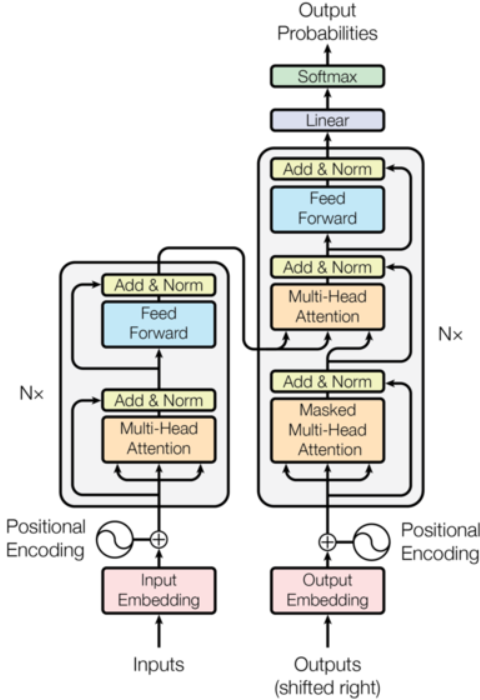
</div>

<div dir=rtl id="Embeddings">
  <font face="XB Zar" size=4>
      <font color="red" size=5>
       Embedding
      </font>

</font>
</div>

<div style="direction:rtl; font-size:15px; color:black"> به ازای هر کلمه ای که به شبکه داده میشود، به راحتی با استفاده از PyTorch به Embedding آن لغت دست پیدا میکنیم.

In [8]:
import torch
import torch.nn as nn

class Embedder(nn.Module):
    def __init__(self, vocab_size, d_model):
        super().__init__()
        self.embed = nn.Embedding(vocab_size, d_model)
        
    def forward(self, x):
        return self.embed(x)

<div dir=rtl id="PE">
  <font face="XB Zar" size=4>
      <font color="red" size=5>
       Positional Encoding
      </font>

</font>
</div>

<div style="direction:rtl; font-size:15px; color:black"> برای پیاده سازی این قسمت هم نکته خاصی وجود ندارد و صرفا فرمولی که برای Positional Encoding گفته شده است پیاده سازی شده. فقط در متد forward که در ابتدا embedding ورودی یعنی x را در یک ثابت ضرب کردیم تا مقدار آن بزرگتر شود تا در نهایت positional encoding کوچکتری داشته باشیم.

In [9]:
class PositionalEncoder(nn.Module):
    def __init__(self, d_model, max_seq_len = 80):
        super().__init__()
        self.d_model = d_model
         
        # create constant 'pe' matrix with values dependant on
        # pos and i
        pe = torch.zeros(max_seq_len, d_model)
        for pos in range(max_seq_len):
            for i in range(0, d_model, 2):
                pe[pos, i] = math.sin(pos / (10000 ** ((2 * i)/d_model)))
                pe[pos, i + 1] = math.cos(pos / (10000 ** ((2 * (i + 1))/d_model)))
                 
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)
  
     
    def forward(self, x):
        # make embeddings relatively larger
        x = x * math.sqrt(self.d_model)
        
        #add constant to embedding
        seq_len = x.size(1)
        x = x + Variable(self.pe[:,:seq_len], requires_grad=False).cuda()
        
        return x

<div dir=rtl id="Masks">
  <font face="XB Zar" size=4>
      <font color="red" size=5>
       Masks
      </font>

</font>
</div>

<div style="direction:rtl; font-size:15px; color:black"> پیاده سازی mask هم برای قسمت encoder و هم برای decoder بسیار مهم است. این بخش دو وظیفه را انجام میدهد: <br><br>
<li>
 Attention را برای جاهایی از ورودی که فقط padding هست صفر میکند.
</li>
<li>
 همچنین در decoder وقتی میخواهیم کلمه بعدی را پیش بینی کنیم، اجازه جلو افتادن (تمرکز بر روی کلمه های جلوتر) را نمیدهد.
</li>

In [ ]:
## Creating Mask for the input

batch = next(iter(train_iter))
input_seq = batch.English.transpose(0,1)
input_pad = EN_TEXT.vocab.stoi['<pad>']

# creates mask with 0s wherever there is padding in the input
input_msk = (input_seq != input_pad).unsqueeze(1)

In [ ]:
## Creating Mask for the target_seq (output)

target_seq = batch.French.transpose(0,1)
target_pad = FR_TEXT.vocab.stoi['<pad>']
target_msk = (target_seq != target_pad).unsqueeze(1)
     
size = target_seq.size(1) # get seq_len for matrix
 
nopeak_mask = np.triu(np.ones(1, size, size),
k=1).astype('uint8')
nopeak_mask = Variable(torch.from_numpy(nopeak_mask) == 0)
 
target_msk = target_msk & nopeak_mask

<div dir=rtl id="MHA">
  <font face="XB Zar" size=4>
      <font color="red" size=5>
       Multi-Head Attention layer
      </font>

</font>
</div>

<div style="direction:rtl; font-size:15px; color:black"> شکل زیر هم شهود بسیار خوبی برای پیاده سازی این قسمت به شما میدهد.

<div>
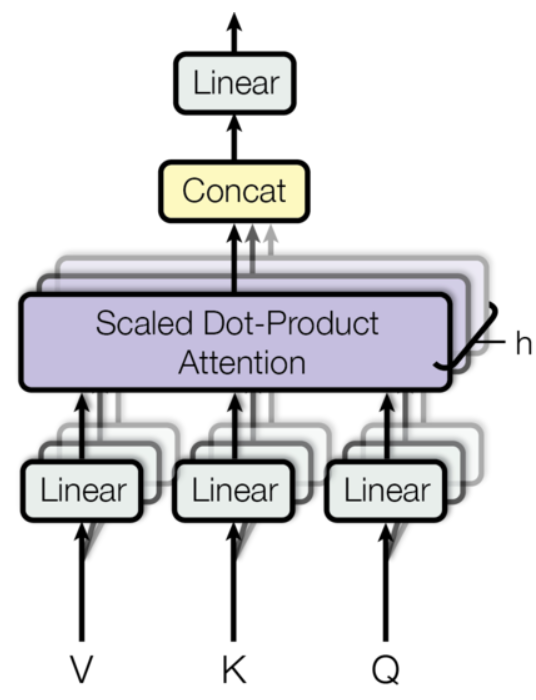
</div>

In [ ]:
class MultiHeadAttention(nn.Module):
    def __init__(self, heads, d_model, dropout = 0.1):
        super().__init__()
         
        self.d_model = d_model
        self.d_k = d_model // heads
        self.h = heads
         
        self.q_linear = nn.Linear(d_model, d_model)
        self.v_linear = nn.Linear(d_model, d_model)
        self.k_linear = nn.Linear(d_model, d_model)
        self.dropout = nn.Dropout(dropout)
        self.out = nn.Linear(d_model, d_model)
     
    def forward(self, q, k, v, mask=None):
         
        bs = q.size(0)
         
        # perform linear operation and split into h heads
         
        k = self.k_linear(k).view(bs, -1, self.h, self.d_k)
        q = self.q_linear(q).view(bs, -1, self.h, self.d_k)
        v = self.v_linear(v).view(bs, -1, self.h, self.d_k)
         
        # transpose to get dimensions bs * h * sl * d_model
        
        k = k.transpose(1,2)
        q = q.transpose(1,2)
        v = v.transpose(1,2)
 
        # calculate attention using function we will define next
        scores = attention(q, k, v, self.d_k, mask, self.dropout)
         
        # concatenate heads and put through final linear layer
        concat = scores.transpose(1,2).contiguous().view(bs, -1, self.d_model)
         
        output = self.out(concat)
     
        return output

In [ ]:
def attention(q, k, v, d_k, mask=None, dropout=None):
     
    scores = torch.matmul(q, k.transpose(-2, -1)) /  math.sqrt(d_k)
 
    if mask is not None:
        mask = mask.unsqueeze(1)
        scores = scores.masked_fill(mask == 0, -1e9)
    scores = F.softmax(scores, dim=-1)
     
    if dropout is not None:
        scores = dropout(scores)
         
    output = torch.matmul(scores, v)
    return output

<div dir=rtl id="FF">
  <font face="XB Zar" size=4>
      <font color="red" size=5>
       Feed-Forward layer
      </font>

</font>
</div>

<div style="direction:rtl; font-size:15px; color:black"> این لایه، لایه بسیار ساده ای است که برای عمیق کردن شبکه مان وجود دارد.

In [ ]:
class FeedForward(nn.Module):
    def __init__(self, d_model, d_ff=2048, dropout = 0.1):
        super().__init__()
        
        # We set d_ff as a default to 2048
        self.linear_1 = nn.Linear(d_model, d_ff)
        self.dropout = nn.Dropout(dropout)
        self.linear_2 = nn.Linear(d_ff, d_model)
        
    def forward(self, x):
        x = self.dropout(F.relu(self.linear_1(x)))
        x = self.linear_2(x)
        
        return x

<div style="direction:rtl; font-size:15px; color:black"> یکی از مهمترین قسمت های پیاده سازی شبکه عصبی عمیق همانطور که پیشتر هم در درس دیدیم، بحث normalization کردن است. این کار مانع بزرگ شدن زیاد از حد خروجی های لایه های شبکه میشود و این به معنی train شدن سریعتر مدل است.

In [ ]:
class Norm(nn.Module):
    def __init__(self, d_model, eps = 1e-6):
        super().__init__()
     
        self.size = d_model
        # create two learnable parameters to calibrate normalisation
        self.alpha = nn.Parameter(torch.ones(self.size))
        self.bias = nn.Parameter(torch.zeros(self.size))
        self.eps = eps
        
    def forward(self, x):
        norm = self.alpha * (x - x.mean(dim=-1, keepdim=True)) / (x.std(dim=-1, keepdim=True) + self.eps) + self.bias
        
        return norm

<div dir=rtl id="En_De">
  <font face="XB Zar" size=4>
      <font color="red" size=5>
       ساخت Encoder و Decoder
      </font>

</font>
</div>

<div style="direction:rtl; font-size:15px; color:black"> با توجه به اینکه تمام ماژول ها و المان های شکل اولیه را ساختیم، میتوانیم یک لایه Encoder و یک لایه Decoder بسازیم که با کلاس های EncoderLayer و DecoderLayer این کار را میکنیم. حال همانطور که در شکل اولیه هم مشخص است ما میتوانیم N لایه در کنار هم از این جفت Encoder و Decoder داشته باشیم که این کار را با تابع get_clones انجام میدهیم.

In [ ]:
class EncoderLayer(nn.Module):
    def __init__(self, d_model, heads, dropout = 0.1):
        super().__init__()
        self.norm_1 = Norm(d_model)
        self.norm_2 = Norm(d_model)
        self.attn = MultiHeadAttention(heads, d_model)
        self.ff = FeedForward(d_model)
        self.dropout_1 = nn.Dropout(dropout)
        self.dropout_2 = nn.Dropout(dropout)
         
    def forward(self, x, mask):
        x2 = self.norm_1(x)
        x = x + self.dropout_1(self.attn(x2,x2,x2,mask))
        x2 = self.norm_2(x)
        x = x + self.dropout_2(self.ff(x2))
        return x
     
class DecoderLayer(nn.Module):
    def __init__(self, d_model, heads, dropout=0.1):
        super().__init__()
        self.norm_1 = Norm(d_model)
        self.norm_2 = Norm(d_model)
        self.norm_3 = Norm(d_model)
         
        self.dropout_1 = nn.Dropout(dropout)
        self.dropout_2 = nn.Dropout(dropout)
        self.dropout_3 = nn.Dropout(dropout)
         
        self.attn_1 = MultiHeadAttention(heads, d_model)
        self.attn_2 = MultiHeadAttention(heads, d_model)
        self.ff = FeedForward(d_model).cuda()
        
    def forward(self, x, e_outputs, src_mask, trg_mask):
        x2 = self.norm_1(x)
        x = x + self.dropout_1(self.attn_1(x2, x2, x2, trg_mask))
        x2 = self.norm_2(x)
        x = x + self.dropout_2(self.attn_2(x2, e_outputs, e_outputs,
        src_mask))
        x2 = self.norm_3(x)
        x = x + self.dropout_3(self.ff(x2))
        return x
    
def get_clones(module, N):
    return nn.ModuleList([copy.deepcopy(module) for i in range(N)])

<div style="direction:rtl; font-size:15px; color:black"> در نهایت هم ماژول های Encoder و Decoder را با N لایه میسازیم.

In [ ]:
class Encoder(nn.Module):
    def __init__(self, vocab_size, d_model, N, heads):
        super().__init__()
        self.N = N
        self.embed = Embedder(vocab_size, d_model)
        self.pe = PositionalEncoder(d_model)
        self.layers = get_clones(EncoderLayer(d_model, heads), N)
        self.norm = Norm(d_model)
        
    def forward(self, src, mask):
        x = self.embed(src)
        x = self.pe(x)
        for i in range(N):
            x = self.layers[i](x, mask)
            
        return self.norm(x)
     
class Decoder(nn.Module):
    def __init__(self, vocab_size, d_model, N, heads):
        super().__init__()
        self.N = N
        self.embed = Embedder(vocab_size, d_model)
        self.pe = PositionalEncoder(d_model)
        self.layers = get_clones(DecoderLayer(d_model, heads), N)
        self.norm = Norm(d_model)
        
    def forward(self, trg, e_outputs, src_mask, trg_mask):
        x = self.embed(trg)
        x = self.pe(x)
        for i in range(self.N):
            x = self.layers[i](x, e_outputs, src_mask, trg_mask)
            
        return self.norm(x)

<div dir=rtl id="Transformer">
  <font face="XB Zar" size=4>
      <font color="red" size=5>
       ساخت Transformer
      </font>

</font>
</div>

In [ ]:
class Transformer(nn.Module):
    def __init__(self, src_vocab, trg_vocab, d_model, N, heads):
        super().__init__()
        self.encoder = Encoder(src_vocab, d_model, N, heads)
        self.decoder = Decoder(trg_vocab, d_model, N, heads)
        self.out = nn.Linear(d_model, trg_vocab)
        
    def forward(self, src, trg, src_mask, trg_mask):
        e_outputs = self.encoder(src, src_mask)
        d_output = self.decoder(trg, e_outputs, src_mask, trg_mask)
        output = self.out(d_output)
        
        return output

<div dir=rtl id="Sentiment_Analysis">
  <font face="XB Zar" size=4>
      <font color="green" size=5>
       Sentiment Analysis با استفاده از Transformer
      </font>

</font>
</div>